In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

os.getcwd()

'/scratch/magr4826/Promotion/RPA_calc'

In [2]:
os.chdir("calc")

In [3]:
def get_cputime(logdir):
    # Parse the cpu time from the .lsf log-files
    with open(logdir, "r") as f:
        log = f.read()

    # Extract number of cores
    cores_match = re.search(r"#BSUB -n (\d+)", log)
    num_cores = int(cores_match.group(1)) if cores_match else None

    # Extract run time
    runtime_match = re.search(r"Run time\s*:\s*(\d+)\s*sec", log)
    run_time_sec = int(runtime_match.group(1)) if runtime_match else None

    if run_time_sec == None or num_cores == None:
        raise (Exception, "Logfile unfinished")

    return num_cores, run_time_sec

## Full cpu time

In [4]:
unfinished = 0
cores = []
runtimes = []
for folder in os.listdir():
    if "agm" in folder:
        os.chdir(folder)
        for file in os.listdir():
            if "log" in file:
                try:
                    cpu, time = get_cputime(file)
                    # print(file)
                    cores.append(cpu)
                    runtimes.append(time)
                except:
                    unfinished += 1

        os.chdir(os.pardir)
cores = np.array(cores)
runtimes = np.array(runtimes)
print(unfinished)

3


Median CPU time per material: 9.568888888888889 h
Mean CPU time per material: 36.28021216652009 h


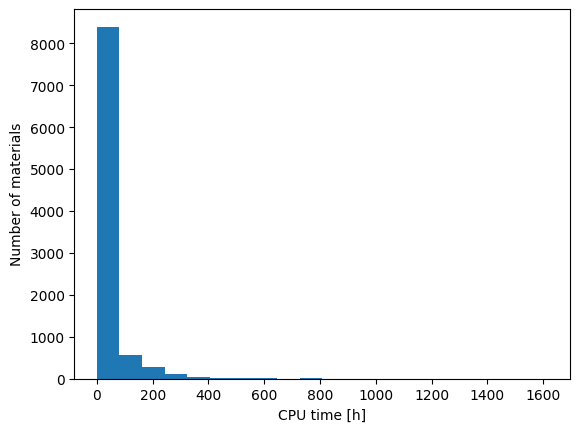

In [8]:
plt.hist(cores * runtimes / 60 / 60, bins=20)
plt.xlabel("CPU time [h]")
plt.ylabel("Number of materials")
print(
    "Median CPU time per material: " + str(np.median(runtimes * cores / 60 / 60)) + " h"
)
print("Mean CPU time per material: " + str(np.mean(runtimes * cores / 60 / 60)) + " h")

## CPU time per RPA step

In [9]:
import re


def parse_yambo_time(timestr):
    """Parse Yambo timing strings like '01d-12h-47m', '01h-29m', '06m-24s', '47s' into seconds."""
    if timestr is None:
        return 0

    # Check for unknown units (anything not d, h, m, s, digits, or dash)
    if re.search(r"[^0-9dhms\-]", timestr):
        raise ValueError(f"Unknown time unit in timing string: {timestr}")

    d = h = m = s = 0
    d_match = re.search(r"(\d+)d", timestr)
    h_match = re.search(r"(\d+)h", timestr)
    m_match = re.search(r"(\d+)m", timestr)
    s_match = re.search(r"(\d+)[-]?s", timestr)

    if d_match:
        d = int(d_match.group(1))
    if h_match:
        h = int(h_match.group(1))
    if m_match:
        m = int(m_match.group(1))
    if s_match:
        s = int(s_match.group(1))

    return d * 86400 + h * 3600 + m * 60 + s


def parse_yambo_log(log_text):
    # Extract number of cores from X_CPU
    xcpu_match = re.search(r'X_CPU=\s*"([\d.]+)"', log_text)
    num_cores = (
        np.prod([int(x) for x in xcpu_match.group(1).split(".")])
        if xcpu_match
        else None
    )

    # Extract average timing string
    timing_match = re.search(
        r"Timing\s+\[Min/Max/Average\]:\s+[^\n/]+/[^\n/]+/([^\s]+)", log_text
    )
    avg_time_str = timing_match.group(1) if timing_match else None
    avg_wall_time = parse_yambo_time(avg_time_str)

    # Compute total CPU time
    total_cpu_time = num_cores * avg_wall_time if num_cores is not None else None

    return {
        "cores": num_cores,
        "avg_wall_time_s": avg_wall_time,
        "cpu_time_s": total_cpu_time,
    }

In [31]:
G_0 = []
for material in os.listdir():
    os.chdir(material + "/yambo_RPA_convergence")
    files = [f for f in os.listdir() if f.startswith("epsilon")]
    G_vals = []
    for file in files:
        epsI_0 = None
        epsI_1 = None
        epsI_2 = None
        if file.startswith("epsilon_0_1500_"):
            with open(file) as f:
                log_text = f.read()
            eps_df = pd.read_csv(
                file,
                comment="#",
                names=["E", "epsi", "epsr", "epsi_o", "epsr_o"],
                sep=r"\s+",
            )
            G_0.append(
                [
                    material,
                    int(file[15:]),
                    parse_yambo_log(log_text)["cpu_time_s"],
                    0,
                    eps_df.epsi.values,
                ]
            )

        if file.startswith("epsilon_1_1500_"):
            with open(file) as f:
                log_text = f.read()
            eps_df = pd.read_csv(
                file,
                comment="#",
                names=["E", "epsi", "epsr", "epsi_o", "epsr_o"],
                sep=r"\s+",
            )
            G_0.append(
                [
                    material,
                    int(file[15:]),
                    parse_yambo_log(log_text)["cpu_time_s"],
                    1,
                    eps_df.epsi.values,
                ]
            )
        if file.startswith("epsilon_2_1500_"):
            with open(file) as f:
                log_text = f.read()
            eps_df = pd.read_csv(
                file,
                comment="#",
                names=["E", "epsi", "epsr", "epsi_o", "epsr_o"],
                sep=r"\s+",
            )
            G_0.append(
                [
                    material,
                    int(file[15:]),
                    parse_yambo_log(log_text)["cpu_time_s"],
                    2,
                    eps_df.epsi.values,
                ]
            )

    os.chdir(os.pardir)
    os.chdir(os.pardir)

time_df = pd.DataFrame(G_0, columns=["mat_id", "G", "time", "dir", "epsI"])

In [110]:
chosen_G = 0
print(f"Mean CPU time (minutes) per material for G={chosen_G}: {time_df[time_df["G"] == chosen_G].groupby("mat_id")["time"].sum().mean()/60}")
print(f"Median CPU time (minutes) per material for G={chosen_G}: {time_df[time_df["G"] == chosen_G].groupby("mat_id")["time"].sum().median()/60}")
chosen_G = 2000
print(f"Mean CPU time (minutes) per material for G={chosen_G}: {time_df[time_df["G"] == chosen_G].groupby("mat_id")["time"].sum().mean()/60}")
print(f"Median CPU time (minutes) per material for G={chosen_G}: {time_df[time_df["G"] == chosen_G].groupby("mat_id")["time"].sum().median()/60}")

Mean CPU time (minutes) per material for G=0: 8.673110177865613
Median CPU time (minutes) per material for G=0: 4.933333333333334
Mean CPU time (minutes) per material for G=2000: 310.81446805006584
Median CPU time (minutes) per material for G=2000: 94.4


## SC for intermediate G-values

In [80]:
import math


# this was written by ChatGPT
def dir_filled_row(row):
    """Return list of spectra (arrays) for the three dirs,
    copying dir-0 whenever a dir is missing *or* NaN."""
    dir0 = np.asarray(row[0])  # must exist
    filled = []
    for d in dirs_needed:
        val = row.get(d, np.nan)  # grab value or NaN
        if isinstance(val, float) and math.isnan(val):
            val = dir0  # replace NaN with dir-0
        filled.append(np.asarray(val))
    return filled


def mean_over_dirs(row):
    """Element-wise mean of the three direction spectra."""
    return np.mean(np.vstack(dir_filled_row(row)), axis=0)

In [81]:
chosen_G = 0
dirs_needed = [0, 1, 2]  # Cartesian directions we expect


at_G = time_df[time_df["G"] == chosen_G].pivot_table(
    index="mat_id", columns="dir", values="epsI", aggfunc="first"
)
mean_epsI_G = at_G.apply(mean_over_dirs, axis=1)  # Series: mat_id → array


idx = time_df.groupby(["mat_id", "dir"])["G"].idxmax()  # row-index of max G
conv = time_df.loc[idx].pivot_table(  # only those rows
    index="mat_id", columns="dir", values="epsI", aggfunc="first"
)
mean_epsI_conv = conv.apply(mean_over_dirs, axis=1)  # Series: mat_id → array

SC = 1 - np.trapezoid(
    np.abs(np.stack(mean_epsI_G) - np.stack(mean_epsI_conv)), axis=1
) / np.trapezoid(np.stack(mean_epsI_conv), axis=1)
print(f"Mean SC at G={chosen_G}: {np.mean(SC)}")
print(f"Median SC at G={chosen_G}: {np.median(SC)}")

Mean SC at G=0: 0.6713656053099827
Median SC at G=0: 0.6839544858025914


In [82]:
chosen_G = 2000
dirs_needed = [0, 1, 2]  # Cartesian directions we expect


at_G = time_df[time_df["G"] == chosen_G].pivot_table(
    index="mat_id", columns="dir", values="epsI", aggfunc="first"
)
mean_epsI_G = at_G.apply(mean_over_dirs, axis=1)  # Series: mat_id → array


idx = time_df.groupby(["mat_id", "dir"])["G"].idxmax()  # row-index of max G
conv = time_df.loc[idx].pivot_table(  # only those rows
    index="mat_id", columns="dir", values="epsI", aggfunc="first"
)
mean_epsI_conv = conv.apply(mean_over_dirs, axis=1)  # Series: mat_id → array

SC = 1 - np.trapezoid(
    np.abs(np.stack(mean_epsI_G) - np.stack(mean_epsI_conv)), axis=1
) / np.trapezoid(np.stack(mean_epsI_conv), axis=1)
print(f"Mean SC at G={chosen_G}: {np.mean(SC)}")
print(f"Median SC at G={chosen_G}: {np.median(SC)}")

Mean SC at G=2000: 0.9715463901878577
Median SC at G=2000: 0.9738197751180502
